# Import Packages

In [1]:
# Import packages
import random
import math
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from scipy.stats import beta, f_oneway, kruskal, ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from collections import OrderedDict

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

# Algorithms 
* Random (for baseline comparison)
* Without tuning
 * Epsilon Decay
 * Annealing Softmax
 * UCB1
 * Bayesian UCB
 * Thompson Sampling
* With Tuning
 * Epsilon Greedy
 * Softmax

### Random

In [2]:
def random_policy(history, arms):
    chosen_arm = np.random.choice(arms, replace = False)
    return chosen_arm

## Algorithms Without Tuning
* Epsilon Decay
* Annealing Softmax
* UCB1
* Bayesian UCB
* Thompson Sampling

### Epsilon Decay

In [3]:
def epsilon_decay(history, arms):
    
    epsilon = 1 / (sum(history["count"]) / len(arms) + 1)
    
    if random.random() > epsilon: # exploit
        ranks = history.sort_values(by = ['mean'], ascending = False) 
        chosen_arm = ranks.iloc[0]['arm']
    else: # explore
        chosen_arm = np.random.choice(arms, replace = False)
    
    return chosen_arm

### Annealing Softmax

In [4]:
def annealing_softmax(history, arms):
    
    temp = 1 / (sum(history["count"]) / len(arms) + 1)

    z = sum([np.exp(v / temp) for v in history["mean"]])
    pi = [np.exp(v / temp) / z for v in history["mean"]]
    chosen_arm = np.random.choice(arms, p = pi)
    
    return chosen_arm

### UCB1 (CHECK)

In [5]:
def ucb1(history, arms):

    n_arms = len(arms)
    
    for arm in range(n_arms):
        if int(history["count"][arm]) == 0:
            chosen_arm = history["arm"][arm]
            return chosen_arm
    
    ucb_values = [0.0 for arm in range(n_arms)]
    total_counts = sum(history["count"])
    
    for arm in range(n_arms):
        bonus = math.sqrt((2*math.log(total_counts)) / (float(history["count"][arm])))
        ucb_values[arm] = history["mean"][arm] + bonus
    
    chosen_arm = ucb_values.index(max(ucb_values)) + 1
    
    return chosen_arm

### Bayesian UCB (CHECK)

In [6]:
def bayesian_ucb(history, arms):
    
    n_arms = len(arms)
    
    chosen_arm = max(range(n_arms), 
                     key = lambda x: container["alpha"][x] / float(container["alpha"][x] + container["beta"][x]) 
                     + beta.std(container["alpha"][x], container["beta"][x]) * 3) + 1
    
    return chosen_arm

### Thompson Sampling (CHECK)

In [7]:
def thompson_sampling(history, arms):
    
    n_arms = len(arms)
    
    thetas = [np.random.beta(container["alpha"][x], container["beta"][x]) for x in range(n_arms)]
    chosen_arm = max(range(n_arms), 
                     key = lambda x: thetas[x]) + 1
    
    return chosen_arm

## Algorithm with Tuning
* Epsilon Greedy
* Softmax

### Epsilon Greedy (CHECK)

In [8]:
def epsilon_greedy(history, arms, epsilon):
    
    explore = np.random.binomial(1, epsilon)
            
    if explore == 1 or history.shape[0] == 0:
        chosen_arm = np.random.choice(arms, replace=False)
    else:
        ranks = history.sort_values(by=['mean'], ascending=False) 
        chosen_arm = ranks.iloc[0]['arm']
        
    return chosen_arm

### Softmax

In [9]:
def softmax(history, arms, temp):
    
    z = sum([math.exp(v / temp) for v in history["mean"]])
    pi = [math.exp(v / temp) / z for v in history["mean"]]
    chosen_arm = np.random.choice(arms, p = pi)
    
    return chosen_arm

### LinUCB

In [10]:
def linucb(history, arms, context, alpha = 0.5):
    scores = np.zeros(len(arms))
    thetas = [np.zeros(2) for _ in range(len(arms))]
    for arm in range(len(arms)):
        A_inv = np.linalg.inv(history['A'][arm])
        theta = A_inv @ history['b'][arm]
        # context_arm = np.array(np.random.uniform(low = 0, high = 1, size = 2)) * context
        p_arm = theta.T @ context + alpha * np.sqrt(context.T @ A_inv @ context)
        scores[arm] = p_arm
        thetas[arm] = theta
    chosen_arm = np.argmax(scores) + 1
    return chosen_arm

### LinTS

In [11]:
def linTS(history, arms, context, v = 0.2):
    scores = np.zeros(len(arms))
    thetas = [np.zeros(2) for _ in range(len(arms))]
    for arm in range(len(arms)):
        mu_tilde = np.random.multivariate_normal(container['mu_hat'][arm].flat, v**2 * np.linalg.inv(container['B'][arm]))[..., np.newaxis]
        # theta = 1/(1+np.exp(-1 * container['F'][arm]))
        theta = 1/(1+np.exp(-1 * container['B'][arm].dot(container['mu_hat'][arm])))
        scores[arm] = context.dot(mu_tilde)
        thetas[arm] = theta
    chosen_arm = np.argmax(scores) + 1
    return chosen_arm

# Plots

In [12]:
def plot_multiple_boxplots(data: pd.DataFrame, grouped_col: str, target_col: str,
                           palette: str = "husl"):
    plt.figure(figsize=(12, 10))

    means: dict = data.groupby([grouped_col])[target_col].mean().to_dict(OrderedDict)
    counter: int = 0

    bp = sns.boxplot(x=grouped_col, y=target_col, data=data, palette=palette, order=list(means.keys()))
    bp.set(xlabel='', ylabel=f"{target_col.title()}")
    ax = bp.axes

    for k, v in means.items():
        mean = round(v, 2)
        ax.text(
            counter,
            mean,
            f'{mean}',
            ha='center',
            va='center',
            fontweight='bold',
            size=10,
            color='white',
            bbox=dict(facecolor='#445A64'))
        counter += 1
    bp.figure.tight_layout()
    plt.grid()
    plt.show()

In [13]:
def get_labels_colors_from_pandas_column(df: pd.DataFrame, column: str, palette: str):
    data_labels: dict = dict()
    labels: list = df[column].unique().tolist()
    colors: list = sns.color_palette(palette, len(labels))
    data_labels: dict = dict(zip(labels, colors))
    return data_labels

# Bootstrap Replay

In the bootstrapped replay, please output a dataframe, which contains the following columns: policy, time_step, reward, cumulative_reward

In [14]:
logs_df = pd.read_csv("../Data Cleaning/cleaned_dataset.csv")
# logs_df = pd.read_csv("cleaned_dataset.csv")
# logs_df = pd.read_csv("cleaned_dataset_all.csv")
logs_df.loc[logs_df['AGE'] == 'OLD', 'AGE_new'] = 1
logs_df.loc[logs_df['AGE'] == 'YOUNG', 'AGE_new'] = 0
logs_df["AGE_new"] = logs_df["AGE_new"].astype(int)
# GENDER: M = 1, F = 0
logs_df.loc[logs_df['SEX'] == 'M', 'SEX_new'] = 1
logs_df.loc[logs_df['SEX'] == 'F', 'SEX_new'] = 0
logs_df["SEX_new"] = logs_df["SEX_new"].astype(int)
logs_df

,SEX,AGE,RXASP,RXHEP,FDEAD,FDENNIS,FRECOVER,RXHEP_1,TREATMENT,REWARD_BERNOULLI,REWARD_CATEGORICAL,REWARD_VALUE (BER),REWARD_VALUE (CAT),AGE_new,SEX_new
0,M,OLD,Y,N,Y,NaN,NaN,N,3,Dead,Dead,0,1,1,1
1,F,YOUNG,Y,L,N,Y,N,L,4,Alive,Alive and still dependent,1,3,0,0
2,F,YOUNG,Y,N,N,N,N,N,3,Alive,Alive and recovered,1,4,0,0
3,F,OLD,N,L,Y,NaN,NaN,L,2,Dead,Dead,0,1,1,0
4,M,OLD,N,N,N,Y,N,N,1,Alive,Alive and still dependent,1,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,F,YOUNG,N,N,N,N,N,N,1,Alive,Alive and recovered,1,4,0,0
2496,M,OLD,Y,N,Y,NaN,NaN,N,3,Dead,Dead,0,1,1,1
2497,M,OLD,N,N,Y,NaN,NaN,N,1,Dead,Dead,0,1,1,1
2498,M,YOUNG,N,N,N,N,N,N,1,Alive,Alive and recovered,1,4,0,1


In [15]:
def get_reward_prob(df):
    rewards_list = ['Alive and still dependent', 'Alive and recovered', 'Dead', 'Alive with unknown status']
    probs_list = []
    for i in range(4):
        prob = sum(df[df["REWARD_CATEGORICAL"] == rewards_list[i]]["REWARD_VALUE (CAT)"]) / sum(df["REWARD_CATEGORICAL"].value_counts())
        probs_list.append(prob)
    probs_list = [x/sum(probs_list) for x in probs_list]
    return probs_list

get_reward_prob(logs_df)

[0.4244332493702771,
 0.48698572628043657,
 0.08466274839070809,
 0.003918275958578225]

In [16]:
# Generate boostrap resamples
def bootstrap_samples(df, n_samples):
    # Creation of bootstrap resamples
    bsamples = []

    for i in range(5):
        bsample = resample(df, replace = True, n_samples = n_samples, random_state = i)
        bsamples.append(bsample)
    
    return bsamples

In [17]:
# Describe your data
arms = logs_df["TREATMENT"].unique()
log_length = logs_df.shape[0]
n_samples = log_length * len(arms)
arms

array([3, 4, 2, 1], dtype=int64)

## Bernoulli Arm

In [18]:
# Set seed for reproducibility
random.seed(4014)
np.random.seed(4014)

# Retrieving resamples
bsamples = bootstrap_samples(logs_df, n_samples)

# The algos used
algos = [random_policy, epsilon_decay, annealing_softmax, ucb1, bayesian_ucb, thompson_sampling, epsilon_greedy, softmax, linucb, linTS]
# algos = [linucb]

# Define a dataframe for evaluation results
evaluation_ber = []

# Define a list to save all arm-play statistics
play_stats = []

# Check algos
count_algos = 0

# Running bootstrap replay
for f in algos:
    
    count_algos += 1
    
    # Count samples
    sample_no = 0

    for bsample in bsamples:
        # Define a container to store all knowledge you have learned for arm
        container_cols = ['arm', 'sum', 'mean', 'count', 'alpha', 'beta', 'A', 'b', 'B', 'mu_hat', 'F']
        container = pd.DataFrame(data = None, columns = container_cols)
        container = container.astype({'arm': 'int32', 'sum': 'float', 'mean': 'float', 'count': 'float', 
                                      'alpha': 'int32', 'beta': 'int32'})
        
        A = np.identity(2) # n_features = 2
        b = np.zeros(2)
        B = np.identity(2)
        mu_hat = np.zeros(2)
        F = np.zeros(2)
        
        for j in range(0, len(arms)):
            container.loc[j] = [arms[j], 0, 0, 0, 1, 1, A, b, B, mu_hat, F]
        
        step = 0
        sample_no += 1

        # Go through every entry of the dataframe
        for i in range(1, log_length* len(arms) + 1):
            # Get recommendation from the algorithm
            if count_algos < 7:
                rec_a = f(container, arms)
            elif count_algos >= 9:
                # Context (for contextual bandits) --> size = n_features
                context = np.array([bsample.iloc[i - 1]['AGE_new'], bsample.iloc[i - 1]['SEX_new']])
                rec_a = f(container, arms, context)
            else:
                rec_a = f(container, arms, 0.1)
            
            # Check if the recommendation matches the record at the step
            # If it does match, add to history so that the reward of this record can be revealed to the algorithm
            if rec_a == bsample.iloc[i - 1]['TREATMENT']:
                step = step + 1 # number of valid record to keep
                action = bsample.iloc[i - 1]['TREATMENT'] # to see which arm is chosen
                reward = bsample.iloc[i - 1]['REWARD_VALUE (BER)'] # get the reward value
                regret = 1 - reward 
                
                # Get features
                sex = bsample.iloc[i - 1]['SEX']
                age = bsample.iloc[i - 1]['AGE']

                # Add to history
                eva_rec = {'policy': f.__name__, 'chosen_arm':action, 'time_step':step, 'sample': sample_no, 'sex': sex, 'age': age, 'reward':reward, 'regret':regret}
                evaluation_ber.append(eva_rec)
                
                # Keeps a record of the recommendation between the bandit and the data
                container['count'] = np.where(container['arm'] == action, container['count'] + 1, container['count'])
                container['sum'] = np.where(container['arm'] == action, container['sum'] + reward, container['sum'])
                container['mean'] = np.where(container['arm'] == action, container['sum'] / (container['count'] + 0.0), container['mean'])
                container['alpha'] = np.where(container['arm'] == action, container['alpha'] + reward, container['alpha'])
                container['beta'] = np.where(container['arm'] == action, container['beta'] + (1 - reward), container['beta'])
                if count_algos == 9:
                    container['A'][action - 1] = container['A'][action - 1] + np.outer(context, context)
                    container['b'][action - 1] = container['b'][action - 1] + reward * context
                if count_algos == 10:
                    container['B'][action - 1] = container['B'][action - 1] + context.dot(context.T)
                    container['F'][action - 1] = container['F'][action - 1] + reward * context
                    container['mu_hat'][action - 1] = np.linalg.inv(container['B'][action - 1]).dot(container['F'][action - 1])
            # If it does not match, discard and move to the next iteration 
            else:
                continue

        container['policy'] = f.__name__
        play_stats.append(container)

In [19]:
evaluation_ber = pd.DataFrame(evaluation_ber)
evaluation_ber_policy = evaluation_ber.sort_values(by=['policy','time_step'])
evaluation_ber_policy

,policy,chosen_arm,time_step,sample,sex,age,reward,regret
25864,annealing_softmax,4,1,1,M,YOUNG,1,0
27711,annealing_softmax,1,1,2,M,YOUNG,0,1
29418,annealing_softmax,1,1,3,M,OLD,0,1
32838,annealing_softmax,1,1,4,M,OLD,1,0
36053,annealing_softmax,3,1,5,F,OLD,0,1
...,...,...,...,...,...,...,...,...
47666,ucb1,1,3415,3,M,YOUNG,1,0
47667,ucb1,1,3416,3,M,OLD,1,0
47668,ucb1,1,3417,3,M,OLD,1,0
47669,ucb1,1,3418,3,F,OLD,0,1


In [20]:
final_evaluation_ber = evaluation_ber_policy.groupby(['policy', 'time_step'], as_index = False).aggregate({"reward":"mean", 
                                                                                                           "regret":"mean"})

final_evaluation_ber['cumulative_reward'] = final_evaluation_ber.groupby(['policy'])['reward'].cumsum()
final_evaluation_ber['cumulative_regret'] = final_evaluation_ber.groupby(['policy'])['regret'].cumsum()
final_evaluation_ber

,policy,time_step,reward,regret,cumulative_reward,cumulative_regret
0,annealing_softmax,1,0.4,0.6,0.400000,0.600000
1,annealing_softmax,2,0.8,0.2,1.200000,0.800000
2,annealing_softmax,3,1.0,0.0,2.200000,0.800000
3,annealing_softmax,4,1.0,0.0,3.200000,0.800000
4,annealing_softmax,5,0.6,0.4,3.800000,1.200000
...,...,...,...,...,...,...
31826,ucb1,3415,1.0,0.0,2575.883333,839.116667
31827,ucb1,3416,1.0,0.0,2576.883333,839.116667
31828,ucb1,3417,1.0,0.0,2577.883333,839.116667
31829,ucb1,3418,0.0,1.0,2577.883333,840.116667


In [21]:
evaluation_ber_treatment = evaluation_ber.sort_values(by=['policy', 'sample', 'time_step'])
evaluation_ber_treatment_F = evaluation_ber_treatment[evaluation_ber_treatment['sex'] == 'F']
evaluation_ber_treatment_M = evaluation_ber_treatment[evaluation_ber_treatment['sex'] == 'M']
evaluation_ber_treatment_Y = evaluation_ber_treatment[evaluation_ber_treatment['age'] == 'YOUNG']
evaluation_ber_treatment_O = evaluation_ber_treatment[evaluation_ber_treatment['age'] == 'OLD']

In [22]:
evaluation_ber_groupedtreatment_F = evaluation_ber_treatment_F.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [23]:
evaluation_ber_groupedtreatment_F = evaluation_ber_groupedtreatment_F.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_ber_groupedtreatment_F

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.642397,0.357603
1,annealing_softmax,2,0.550000,0.450000
2,annealing_softmax,3,0.606578,0.393422
3,annealing_softmax,4,0.698438,0.301562
4,bayesian_ucb,1,0.813515,0.186485
5,bayesian_ucb,2,0.702096,0.297904
6,bayesian_ucb,4,1.000000,0.000000
7,epsilon_decay,1,0.663407,0.336593
8,epsilon_decay,2,0.531250,0.468750
9,epsilon_decay,3,0.718693,0.281307


In [24]:
evaluation_ber_groupedtreatment_M = evaluation_ber_treatment_M.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [25]:
evaluation_ber_groupedtreatment_M = evaluation_ber_groupedtreatment_M.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_ber_groupedtreatment_M

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.750654,0.249346
1,annealing_softmax,2,0.708333,0.291667
2,annealing_softmax,3,0.494590,0.505410
3,annealing_softmax,4,0.828095,0.171905
4,bayesian_ucb,1,0.896907,0.103093
5,bayesian_ucb,2,0.733581,0.266419
6,bayesian_ucb,4,1.000000,0.000000
7,epsilon_decay,1,0.776174,0.223826
8,epsilon_decay,2,0.488095,0.511905
9,epsilon_decay,3,0.655506,0.344494


In [26]:
evaluation_ber_groupedtreatment_Y = evaluation_ber_treatment_Y.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [27]:
evaluation_ber_groupedtreatment_Y = evaluation_ber_groupedtreatment_Y.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_ber_groupedtreatment_Y

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.887629,0.112371
1,annealing_softmax,2,0.800000,0.200000
2,annealing_softmax,3,0.735108,0.264892
3,annealing_softmax,4,0.886961,0.113039
4,bayesian_ucb,1,0.937705,0.062295
5,bayesian_ucb,2,0.825516,0.174484
6,bayesian_ucb,4,1.000000,0.000000
7,epsilon_decay,1,0.904448,0.095552
8,epsilon_decay,2,0.900000,0.100000
9,epsilon_decay,3,0.738185,0.261815


In [28]:
evaluation_ber_groupedtreatment_O = evaluation_ber_treatment_O.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [29]:
evaluation_ber_groupedtreatment_O = evaluation_ber_groupedtreatment_O.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_ber_groupedtreatment_O

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,0.600105,0.399895
1,annealing_softmax,2,0.592760,0.407240
2,annealing_softmax,3,0.447099,0.552901
3,annealing_softmax,4,0.698266,0.301734
4,bayesian_ucb,1,0.834040,0.165960
5,bayesian_ucb,2,0.659922,0.340078
6,bayesian_ucb,4,1.000000,0.000000
7,epsilon_decay,1,0.659460,0.340540
8,epsilon_decay,2,0.440000,0.560000
9,epsilon_decay,3,0.723894,0.276106


## Test Stats

### Comparing between Algorithms
Is there a difference in performance between the different multi-armed bandit algorithms?

In [30]:
epsilon_greedy_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'epsilon_greedy']['reward'])
epsilon_decay_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'epsilon_decay']['reward'])
softmax_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'softmax']['reward'])
annealing_softmax_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'annealing_softmax']['reward'])
ucb1_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'ucb1']['reward'])
bayes_ucb_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'bayesian_ucb']['reward'])
thompson_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'thompson_sampling']['reward'])
linucb_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'linucb']['reward'])
linTS_rewards = list(final_evaluation_ber[final_evaluation_ber['policy'] == 'linTS']['reward'])

f_oneway(epsilon_greedy_rewards, epsilon_decay_rewards, softmax_rewards, annealing_softmax_rewards, 
         ucb1_rewards, bayes_ucb_rewards, thompson_rewards, linucb_rewards, linTS_rewards)

F_onewayResult(statistic=3.239254082429796, pvalue=0.0010902377467636847)

In [31]:
tukey_df_algo_ber = final_evaluation_ber[['policy', 'reward']]

tukey_algo_ber = pairwise_tukeyhsd(endog=tukey_df_algo_ber['reward'],
                                   groups=tukey_df_algo_ber['policy'],
                                   alpha=0.05)

In [32]:
print(tukey_algo_ber)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
annealing_softmax      bayesian_ucb  -0.0098  0.775 -0.0276   0.008  False
annealing_softmax     epsilon_decay   0.0056 0.9929 -0.0122  0.0233  False
annealing_softmax    epsilon_greedy   0.0081 0.9208   -0.01  0.0262  False
annealing_softmax             linTS   0.0143 0.2738 -0.0039  0.0326  False
annealing_softmax            linucb   0.0056 0.9929 -0.0123  0.0235  False
annealing_softmax     random_policy   0.0002    1.0 -0.0192  0.0196  False
annealing_softmax           softmax   0.0037 0.9998 -0.0146  0.0221  False
annealing_softmax thompson_sampling   -0.004 0.9996 -0.0226  0.0146  False
annealing_softmax              ucb1  -0.0047  0.998 -0.0225  0.0131  False
     bayesian_ucb     epsilon_decay   0.0153 0.1622 -0.0024  0.0331  False
     bayesian_ucb    epsi

### Comparing for Treatments 
For each treatment method, is there a difference in performance between different age groups or different sex?


In [33]:
evaluation_ber_groupedtreatment_F1 = evaluation_ber_groupedtreatment_F[evaluation_ber_groupedtreatment_F['chosen_arm'] == 1]
evaluation_ber_groupedtreatment_F2 = evaluation_ber_groupedtreatment_F[evaluation_ber_groupedtreatment_F['chosen_arm'] == 2]
evaluation_ber_groupedtreatment_F3 = evaluation_ber_groupedtreatment_F[evaluation_ber_groupedtreatment_F['chosen_arm'] == 3]
evaluation_ber_groupedtreatment_F4 = evaluation_ber_groupedtreatment_F[evaluation_ber_groupedtreatment_F['chosen_arm'] == 4]

evaluation_ber_groupedtreatment_M1 = evaluation_ber_groupedtreatment_M[evaluation_ber_groupedtreatment_M['chosen_arm'] == 1]
evaluation_ber_groupedtreatment_M2 = evaluation_ber_groupedtreatment_M[evaluation_ber_groupedtreatment_M['chosen_arm'] == 2]
evaluation_ber_groupedtreatment_M3 = evaluation_ber_groupedtreatment_M[evaluation_ber_groupedtreatment_M['chosen_arm'] == 3]
evaluation_ber_groupedtreatment_M4 = evaluation_ber_groupedtreatment_M[evaluation_ber_groupedtreatment_M['chosen_arm'] == 4]

In [34]:
sex_1 = ttest_ind(evaluation_ber_groupedtreatment_F1['reward'], evaluation_ber_groupedtreatment_M1['reward'])
sex_2 = ttest_ind(evaluation_ber_groupedtreatment_F2['reward'], evaluation_ber_groupedtreatment_M2['reward'])
sex_3 = ttest_ind(evaluation_ber_groupedtreatment_F3['reward'], evaluation_ber_groupedtreatment_M3['reward'])
sex_4 = ttest_ind(evaluation_ber_groupedtreatment_F4['reward'], evaluation_ber_groupedtreatment_M4['reward'])
print(f'Treatment 1 (sex): {sex_1}')
print(f'Treatment 2 (sex): {sex_2}')
print(f'Treatment 3 (sex): {sex_3}')
print(f'Treatment 4 (sex): {sex_4}')

Treatment 1 (sex): Ttest_indResult(statistic=-0.03290297723950026, pvalue=0.9741140698533967)
Treatment 2 (sex): Ttest_indResult(statistic=-0.6568165605668596, pvalue=0.5200922326265275)
Treatment 3 (sex): Ttest_indResult(statistic=1.0052148065706277, pvalue=0.32975454984868613)
Treatment 4 (sex): Ttest_indResult(statistic=-0.7657505077354997, pvalue=0.4537497151421469)


In [35]:
evaluation_ber_groupedtreatment_Y1 = evaluation_ber_groupedtreatment_Y[evaluation_ber_groupedtreatment_Y['chosen_arm'] == 1]
evaluation_ber_groupedtreatment_Y2 = evaluation_ber_groupedtreatment_Y[evaluation_ber_groupedtreatment_Y['chosen_arm'] == 2]
evaluation_ber_groupedtreatment_Y3 = evaluation_ber_groupedtreatment_Y[evaluation_ber_groupedtreatment_Y['chosen_arm'] == 3]
evaluation_ber_groupedtreatment_Y4 = evaluation_ber_groupedtreatment_Y[evaluation_ber_groupedtreatment_Y['chosen_arm'] == 4]

evaluation_ber_groupedtreatment_O1 = evaluation_ber_groupedtreatment_O[evaluation_ber_groupedtreatment_O['chosen_arm'] == 1]
evaluation_ber_groupedtreatment_O2 = evaluation_ber_groupedtreatment_O[evaluation_ber_groupedtreatment_O['chosen_arm'] == 2]
evaluation_ber_groupedtreatment_O3 = evaluation_ber_groupedtreatment_O[evaluation_ber_groupedtreatment_O['chosen_arm'] == 3]
evaluation_ber_groupedtreatment_O4 = evaluation_ber_groupedtreatment_O[evaluation_ber_groupedtreatment_O['chosen_arm'] == 4]

In [36]:
age_1 = ttest_ind(evaluation_ber_groupedtreatment_Y1['reward'], evaluation_ber_groupedtreatment_O1['reward'])
age_2 = ttest_ind(evaluation_ber_groupedtreatment_Y2['reward'], evaluation_ber_groupedtreatment_O2['reward'])
age_3 = ttest_ind(evaluation_ber_groupedtreatment_Y3['reward'], evaluation_ber_groupedtreatment_O3['reward'])
age_4 = ttest_ind(evaluation_ber_groupedtreatment_Y4['reward'], evaluation_ber_groupedtreatment_O4['reward'])
print(f'Treatment 1 (age): {age_1}')
print(f'Treatment 2 (age): {age_2}')
print(f'Treatment 3 (age): {age_3}')
print(f'Treatment 4 (age): {age_4}')

Treatment 1 (age): Ttest_indResult(statistic=6.296817122048498, pvalue=6.171890039597928e-06)
Treatment 2 (age): Ttest_indResult(statistic=4.647296935200507, pvalue=0.0002003151193345712)
Treatment 3 (age): Ttest_indResult(statistic=0.5277252081765657, pvalue=0.6049320367125381)
Treatment 4 (age): Ttest_indResult(statistic=2.462666294193572, pvalue=0.02551718952705347)


## Reward
* The average reward over time
* The cumulative reward over time

Text(0.5, 1.0, 'Average rewards at each time step')

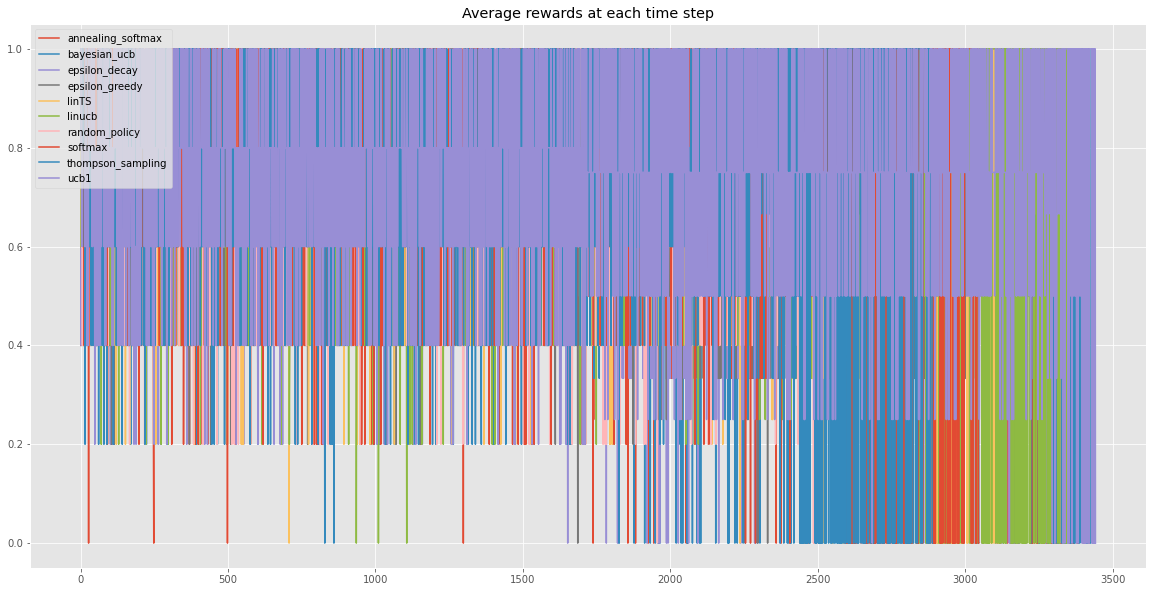

In [37]:
# Plot the rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for policy in final_evaluation_ber['policy'].unique():
    results_policy = final_evaluation_ber[final_evaluation_ber['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['reward'], label = str(policy))

plt.legend(loc = "upper left")
plt.title("Average rewards at each time step")

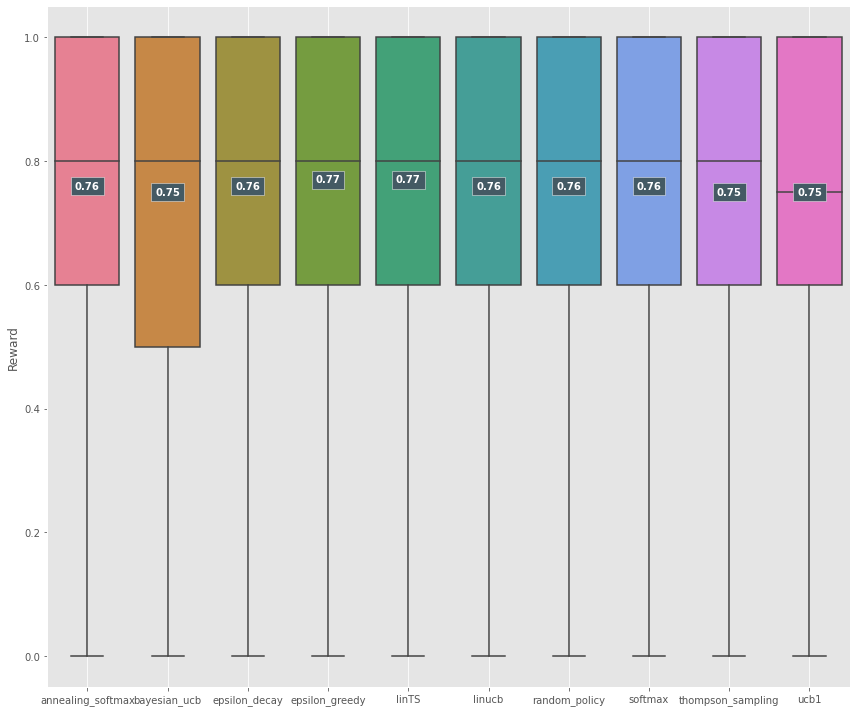

In [38]:
palette: str = "husl"
grouped: str = "policy"
default_value: str = "unknown"
target: str = "reward"

# Retrieve labels and additional parameters to plot figures
data_labels: dict = get_labels_colors_from_pandas_column(df = final_evaluation_ber, column = grouped, palette = palette)

plot_multiple_boxplots(data=final_evaluation_ber,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

In [39]:
# Determine the cumulative reward at 1000 time step
final_evaluation_ber.groupby(['policy'], as_index = False).aggregate({"cumulative_reward":"max"}).sort_values(by=["cumulative_reward"], ascending = False)

,policy,cumulative_reward
2,epsilon_decay,2630.583333
0,annealing_softmax,2594.750000
9,ucb1,2577.883333
1,bayesian_ucb,2565.083333
5,linucb,2556.600000
3,epsilon_greedy,2473.766667
4,linTS,2412.683333
7,softmax,2322.400000
8,thompson_sampling,2180.416667
6,random_policy,1895.683333


Text(0.5, 1.0, 'Cumulative rewards at each step')

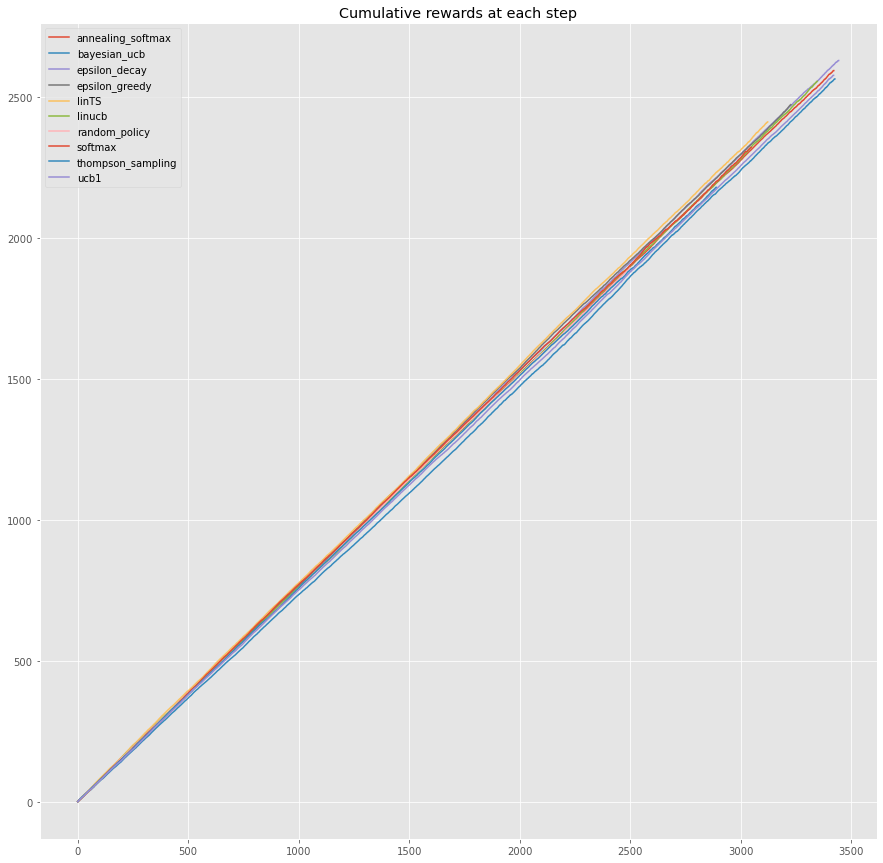

In [40]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation_ber['policy'].unique():
    results_policy = final_evaluation_ber[final_evaluation_ber['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))

plt.legend()
plt.title("Cumulative rewards at each step")

Text(0.5, 1.0, 'Cumulative rewards at each step')

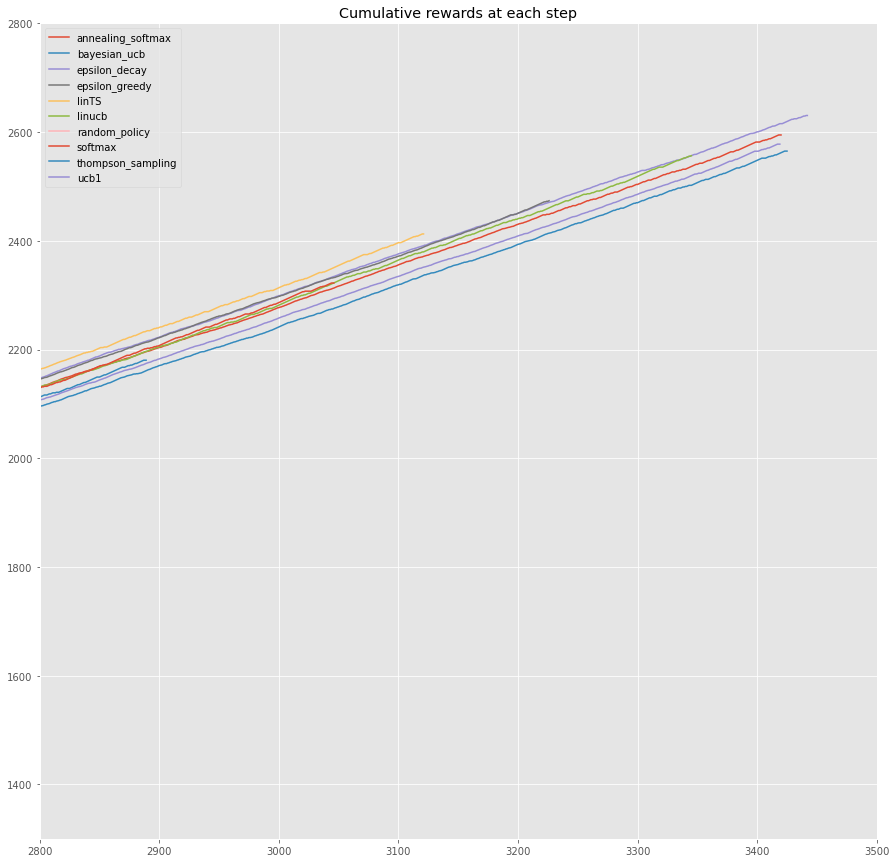

In [41]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation_ber['policy'].unique():
    results_policy = final_evaluation_ber[final_evaluation_ber['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))

plt.xlim(2800, 3500)
plt.ylim(1300, 2800)
plt.legend()
plt.title("Cumulative rewards at each step")

## Categorical Arm

In [42]:
# Set seed for reproducibility
random.seed(4014)
np.random.seed(4014)

# Retrieving resamples
bsamples = bootstrap_samples(logs_df, n_samples)

# The algos used
algos = [random_policy, epsilon_decay, annealing_softmax, ucb1, epsilon_greedy, softmax, linucb, linTS]
# algos = [annealing_softmax]

# Define a dataframe for evaluation results
evaluation_cat = []

# Define a list to save all arm-play statistics
play_stats = []

count_algos = 0

# Running bootstrap replay
for f in algos:
    
    count_algos += 1
    
    # Count samples
    sample_no = 0

    for bsample in bsamples:
        # Define a container to store all knowledge you have learned for arm
        container_cols = ['arm', 'mean', 'count', 'cat_dict', 'A', 'b', 'B', 'mu_hat', 'F']
        container = pd.DataFrame(data = None, columns = container_cols)
        container = container.astype({'arm': 'int32', 'mean': 'float', 'count': 'float'})
        
        A = np.identity(2) # n_features = 2
        b = np.zeros(2)
        B = np.identity(2)
        mu_hat = np.zeros(2)
        F = np.zeros(2)
        
        # To keep track of categories count
        categories_dict = {'Dead': 0, 'Alive and still dependent': 0, 'Alive and recovered': 0, 'Alive with unknown status': 0}
        
        for j in range(0, len(arms)):
            container.loc[j] = [arms[j], 0, 0, categories_dict, A, b, B, mu_hat, F]
        
        step = 0
        sample_no += 1

        # Go through every entry of the dataframe
        for i in range(1, log_length* len(arms) + 1):
            # Get recommendation from the algorithm
            if count_algos < 5:
                rec_a = f(container, arms)
            elif count_algos >= 7:
                # Context (for contextual bandits) --> size = n_features
                context = np.array([bsample.iloc[i - 1]['AGE_new'], bsample.iloc[i - 1]['SEX_new']])
                rec_a = f(container, arms, context)
            else:
                rec_a = f(container, arms, 0.1)
            
            # Check if the recommendation matches the record at the step
            # If it does match, add to history so that the reward of this record can be revealed to the algorithm
            if rec_a == bsample.iloc[i - 1]['TREATMENT']:
                step = step + 1 # number of valid record to keep
                action = bsample.iloc[i - 1]['TREATMENT'] # to see which arm is chosen
                reward = bsample.iloc[i - 1]['REWARD_VALUE (CAT)'] # get the reward value
                regret = 1 - reward
                category = bsample.iloc[i - 1]['REWARD_CATEGORICAL']
                
                # Get features
                sex = bsample.iloc[i - 1]['SEX']
                age = bsample.iloc[i - 1]['AGE']

                # Add to history
                eva_rec = {'policy': f.__name__, 'chosen_arm': action, 'time_step': step, 'sample': sample_no, 'sex': sex, 'age': age, 'reward': reward, 'regret': regret}
                evaluation_cat.append(eva_rec)
                
                # Update reward category
                container['cat_dict'][action - 1][category] = container['cat_dict'][action - 1][category] + 1
                new_estimated_prob = container['cat_dict'][action - 1]['Alive and still dependent'] / sum(container['cat_dict'][action - 1].values())

                # Keeps a record of the recommendation between the bandit and the data
                container['count'] = np.where(container['arm'] == action, container['count'] + 1, container['count'])
                container['mean'] = np.where(container['arm'] == action, new_estimated_prob, container['mean'])
                if count_algos == 7:
                    container['A'][action - 1] = container['A'][action - 1] + np.outer(context, context)
                    container['b'][action - 1] = container['b'][action - 1] + reward * context
                if count_algos == 8:
                    container['B'][action - 1] = container['B'][action - 1] + context.dot(context.T)
                    container['F'][action - 1] = container['F'][action - 1] + reward * context
                    container['mu_hat'][action - 1] = np.linalg.inv(container['B'][action - 1]).dot(container['F'][action - 1])
            # If it does not match, discard and move to the next iteration 
            else:
                continue

        container['policy'] = f.__name__
        play_stats.append(container)

In [43]:
evaluation_cat = pd.DataFrame(evaluation_cat)
evaluation_cat_policy = evaluation_cat.sort_values(by=['policy','time_step'])
evaluation_cat_policy

,policy,chosen_arm,time_step,sample,sex,age,reward,regret
25277,annealing_softmax,3,1,1,F,OLD,4,-3
28110,annealing_softmax,1,1,2,M,YOUNG,1,0
30834,annealing_softmax,2,1,3,M,YOUNG,4,-3
33376,annealing_softmax,2,1,4,F,OLD,1,0
35903,annealing_softmax,1,1,5,F,YOUNG,4,-3
...,...,...,...,...,...,...,...,...
50111,ucb1,1,3376,4,M,OLD,3,-2
50112,ucb1,1,3377,4,M,YOUNG,3,-2
50113,ucb1,1,3378,4,M,OLD,1,0
50114,ucb1,1,3379,4,M,YOUNG,3,-2


In [44]:
final_evaluation_cat = evaluation_cat_policy.groupby(['policy', 'time_step'], as_index = False).aggregate({"reward":"mean", 
                                                                                                           "regret":"mean"})

final_evaluation_cat['cumulative_reward'] = final_evaluation_cat.groupby(['policy'])['reward'].cumsum()
final_evaluation_cat['cumulative_regret'] = final_evaluation_cat.groupby(['policy'])['regret'].cumsum()
final_evaluation_cat

,policy,time_step,reward,regret,cumulative_reward,cumulative_regret
0,annealing_softmax,1,2.8,-1.8,2.800000,-1.800000
1,annealing_softmax,2,2.6,-1.6,5.400000,-3.400000
2,annealing_softmax,3,2.4,-1.4,7.800000,-4.800000
3,annealing_softmax,4,3.0,-2.0,10.800000,-6.800000
4,annealing_softmax,5,3.0,-2.0,13.800000,-8.800000
...,...,...,...,...,...,...
23493,ucb1,3376,3.0,-2.0,9610.766667,-6234.766667
23494,ucb1,3377,3.0,-2.0,9613.766667,-6236.766667
23495,ucb1,3378,1.0,0.0,9614.766667,-6236.766667
23496,ucb1,3379,3.0,-2.0,9617.766667,-6238.766667


In [45]:
evaluation_cat_treatment = evaluation_cat.sort_values(by=['policy', 'sample', 'time_step'])
evaluation_cat_treatment_F = evaluation_cat_treatment[evaluation_cat_treatment['sex'] == 'F']
evaluation_cat_treatment_M = evaluation_cat_treatment[evaluation_cat_treatment['sex'] == 'M']
evaluation_cat_treatment_Y = evaluation_cat_treatment[evaluation_cat_treatment['age'] == 'YOUNG']
evaluation_cat_treatment_O = evaluation_cat_treatment[evaluation_cat_treatment['age'] == 'OLD']

In [46]:
evaluation_cat_groupedtreatment_F = evaluation_cat_treatment_F.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [47]:
evaluation_cat_groupedtreatment_F = evaluation_cat_groupedtreatment_F.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_cat_groupedtreatment_F

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,2.651650,-1.651650
1,annealing_softmax,2,2.675112,-1.675112
2,annealing_softmax,3,2.758854,-1.758854
3,annealing_softmax,4,2.699633,-1.699633
4,epsilon_decay,1,2.632381,-1.632381
5,epsilon_decay,2,2.655753,-1.655753
6,epsilon_decay,3,2.764706,-1.764706
7,epsilon_decay,4,2.755545,-1.755545
8,epsilon_greedy,1,2.687574,-1.687574
9,epsilon_greedy,2,2.735122,-1.735122


In [48]:
evaluation_cat_groupedtreatment_M = evaluation_cat_treatment_M.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [49]:
evaluation_cat_groupedtreatment_M = evaluation_cat_groupedtreatment_M.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_cat_groupedtreatment_M

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,2.997604,-1.997604
1,annealing_softmax,2,2.809359,-1.809359
2,annealing_softmax,3,2.948373,-1.948373
3,annealing_softmax,4,3.093934,-2.093934
4,epsilon_decay,1,2.956698,-1.956698
5,epsilon_decay,2,2.894352,-1.894352
6,epsilon_decay,3,2.976799,-1.976799
7,epsilon_decay,4,3.066567,-2.066567
8,epsilon_greedy,1,3.027167,-2.027167
9,epsilon_greedy,2,2.925652,-1.925652


In [50]:
evaluation_cat_groupedtreatment_Y = evaluation_cat_treatment_Y.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [51]:
evaluation_cat_groupedtreatment_Y = evaluation_cat_groupedtreatment_Y.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_cat_groupedtreatment_Y

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,3.261644,-2.261644
1,annealing_softmax,2,3.122031,-2.122031
2,annealing_softmax,3,3.216810,-2.216810
3,annealing_softmax,4,3.187507,-2.187507
4,epsilon_decay,1,3.266282,-2.266282
5,epsilon_decay,2,3.168442,-2.168442
6,epsilon_decay,3,3.226744,-2.226744
7,epsilon_decay,4,3.216277,-2.216277
8,epsilon_greedy,1,3.290007,-2.290007
9,epsilon_greedy,2,3.173820,-2.173820


In [52]:
evaluation_cat_groupedtreatment_O = evaluation_cat_treatment_O.groupby(['policy', 'sample', 'chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                        "regret":"mean"})

In [53]:
evaluation_cat_groupedtreatment_O = evaluation_cat_groupedtreatment_O.groupby(['policy','chosen_arm'], as_index = False).aggregate({"reward":"mean", 
                                                                                                                                    "regret":"mean"})
evaluation_cat_groupedtreatment_O

,policy,chosen_arm,reward,regret
0,annealing_softmax,1,2.575710,-1.575710
1,annealing_softmax,2,2.536988,-1.536988
2,annealing_softmax,3,2.660408,-1.660408
3,annealing_softmax,4,2.710799,-1.710799
4,epsilon_decay,1,2.513992,-1.513992
5,epsilon_decay,2,2.587166,-1.587166
6,epsilon_decay,3,2.691436,-1.691436
7,epsilon_decay,4,2.712178,-1.712178
8,epsilon_greedy,1,2.604990,-1.604990
9,epsilon_greedy,2,2.647773,-1.647773


## Test Stats

### Comparing between Algorithms
Is there a difference in performance between the different multi-armed bandit algorithms?

In [54]:
epsilon_greedy_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'epsilon_greedy']['reward'])
epsilon_decay_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'epsilon_decay']['reward'])
softmax_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'softmax']['reward'])
annealing_softmax_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'annealing_softmax']['reward'])
ucb1_rewards = list(final_evaluation_cat[final_evaluation_cat['policy'] == 'ucb1']['reward'])

f_oneway(epsilon_greedy_rewards, epsilon_decay_rewards, softmax_rewards, annealing_softmax_rewards, 
         ucb1_rewards, linucb_rewards)

F_onewayResult(statistic=9025.502802609537, pvalue=0.0)

In [55]:
tukey_df_algo_cat = final_evaluation_cat[['policy', 'reward']]

tukey_algo_cat = pairwise_tukeyhsd(endog=tukey_df_algo_cat['reward'],
                                   groups=tukey_df_algo_cat['policy'],
                                   alpha=0.05)

In [56]:
print(tukey_algo_cat)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2     meandiff p-adj   lower  upper  reject
----------------------------------------------------------------------
annealing_softmax  epsilon_decay    0.033 0.3445 -0.0122 0.0783  False
annealing_softmax epsilon_greedy   0.0388 0.1871 -0.0079 0.0856  False
annealing_softmax          linTS   0.0371 0.1701 -0.0068 0.0809  False
annealing_softmax         linucb   0.0293 0.4566 -0.0143 0.0728  False
annealing_softmax  random_policy   0.0178 0.9469 -0.0293 0.0648  False
annealing_softmax        softmax   0.0207 0.8835 -0.0261 0.0674  False
annealing_softmax           ucb1   0.0045    1.0 -0.0392 0.0482  False
    epsilon_decay epsilon_greedy   0.0058 0.9999 -0.0406 0.0523  False
    epsilon_decay          linTS    0.004    1.0 -0.0395 0.0476  False
    epsilon_decay         linucb  -0.0038    1.0  -0.047 0.0395  False
    epsilon_decay  random_policy  -0.0153 0.9762  -0.062 0.0315  False
    ep

### Comparing for Treatments 
For each treatment method, is there a difference in performance between different age groups or different sex?


In [57]:
evaluation_cat_groupedtreatment_F1 = evaluation_cat_groupedtreatment_F[evaluation_cat_groupedtreatment_F['chosen_arm'] == 1]
evaluation_cat_groupedtreatment_F2 = evaluation_cat_groupedtreatment_F[evaluation_cat_groupedtreatment_F['chosen_arm'] == 2]
evaluation_cat_groupedtreatment_F3 = evaluation_cat_groupedtreatment_F[evaluation_cat_groupedtreatment_F['chosen_arm'] == 3]
evaluation_cat_groupedtreatment_F4 = evaluation_cat_groupedtreatment_F[evaluation_cat_groupedtreatment_F['chosen_arm'] == 4]

evaluation_cat_groupedtreatment_M1 = evaluation_cat_groupedtreatment_M[evaluation_cat_groupedtreatment_M['chosen_arm'] == 1]
evaluation_cat_groupedtreatment_M2 = evaluation_cat_groupedtreatment_M[evaluation_cat_groupedtreatment_M['chosen_arm'] == 2]
evaluation_cat_groupedtreatment_M3 = evaluation_cat_groupedtreatment_M[evaluation_cat_groupedtreatment_M['chosen_arm'] == 3]
evaluation_cat_groupedtreatment_M4 = evaluation_cat_groupedtreatment_M[evaluation_cat_groupedtreatment_M['chosen_arm'] == 4]

In [58]:
sex_1 = ttest_ind(evaluation_cat_groupedtreatment_F1['reward'], evaluation_cat_groupedtreatment_M1['reward'])
sex_2 = ttest_ind(evaluation_cat_groupedtreatment_F2['reward'], evaluation_cat_groupedtreatment_M2['reward'])
sex_3 = ttest_ind(evaluation_cat_groupedtreatment_F3['reward'], evaluation_cat_groupedtreatment_M3['reward'])
sex_4 = ttest_ind(evaluation_cat_groupedtreatment_F4['reward'], evaluation_cat_groupedtreatment_M4['reward'])
print(f'Treatment 1 (sex): {sex_1}')
print(f'Treatment 2 (sex): {sex_2}')
print(f'Treatment 3 (sex): {sex_3}')
print(f'Treatment 4 (sex): {sex_4}')

Treatment 1 (sex): Ttest_indResult(statistic=-1.6640075566303256, pvalue=0.11832432957889502)
Treatment 2 (sex): Ttest_indResult(statistic=0.14291941006310646, pvalue=0.8883904167965953)
Treatment 3 (sex): Ttest_indResult(statistic=-3.5357590762769426, pvalue=0.004102709272483003)
Treatment 4 (sex): Ttest_indResult(statistic=-2.8302065374296674, pvalue=0.01516992208764346)


In [59]:
evaluation_cat_groupedtreatment_Y1 = evaluation_cat_groupedtreatment_Y[evaluation_cat_groupedtreatment_Y['chosen_arm'] == 1]
evaluation_cat_groupedtreatment_Y2 = evaluation_cat_groupedtreatment_Y[evaluation_cat_groupedtreatment_Y['chosen_arm'] == 2]
evaluation_cat_groupedtreatment_Y3 = evaluation_cat_groupedtreatment_Y[evaluation_cat_groupedtreatment_Y['chosen_arm'] == 3]
evaluation_cat_groupedtreatment_Y4 = evaluation_cat_groupedtreatment_Y[evaluation_cat_groupedtreatment_Y['chosen_arm'] == 4]

evaluation_cat_groupedtreatment_O1 = evaluation_cat_groupedtreatment_O[evaluation_cat_groupedtreatment_O['chosen_arm'] == 1]
evaluation_cat_groupedtreatment_O2 = evaluation_cat_groupedtreatment_O[evaluation_cat_groupedtreatment_O['chosen_arm'] == 2]
evaluation_cat_groupedtreatment_O3 = evaluation_cat_groupedtreatment_O[evaluation_cat_groupedtreatment_O['chosen_arm'] == 3]
evaluation_cat_groupedtreatment_O4 = evaluation_cat_groupedtreatment_O[evaluation_cat_groupedtreatment_O['chosen_arm'] == 4]

In [60]:
age_1 = ttest_ind(evaluation_cat_groupedtreatment_Y1['reward'], evaluation_cat_groupedtreatment_O1['reward'])
age_2 = ttest_ind(evaluation_cat_groupedtreatment_Y2['reward'], evaluation_cat_groupedtreatment_O2['reward'])
age_3 = ttest_ind(evaluation_cat_groupedtreatment_Y3['reward'], evaluation_cat_groupedtreatment_O3['reward'])
age_4 = ttest_ind(evaluation_cat_groupedtreatment_Y4['reward'], evaluation_cat_groupedtreatment_O4['reward'])
print(f'Treatment 1 (age): {age_1}')
print(f'Treatment 2 (age): {age_2}')
print(f'Treatment 3 (age): {age_3}')
print(f'Treatment 4 (age): {age_4}')

Treatment 1 (age): Ttest_indResult(statistic=14.295908198168954, pvalue=9.59790455511558e-10)
Treatment 2 (age): Ttest_indResult(statistic=11.344239993017757, pvalue=4.0881770190823044e-08)
Treatment 3 (age): Ttest_indResult(statistic=6.315040349046014, pvalue=3.860084239971298e-05)
Treatment 4 (age): Ttest_indResult(statistic=3.1719700976988023, pvalue=0.008887370713684378)


## Reward

Text(0.5, 1.0, 'Average rewards at each time step')

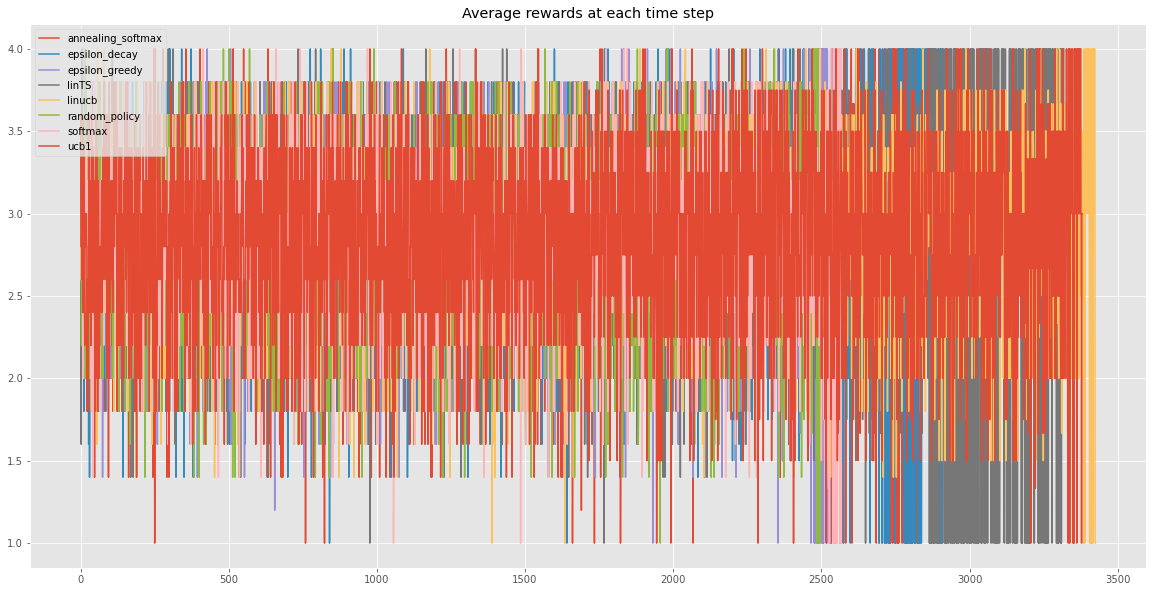

In [61]:
# Plot the rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
for policy in final_evaluation_cat['policy'].unique():
    results_policy = final_evaluation_cat[final_evaluation_cat['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['reward'], label = str(policy))
plt.legend(loc = "upper left")
plt.title("Average rewards at each time step")

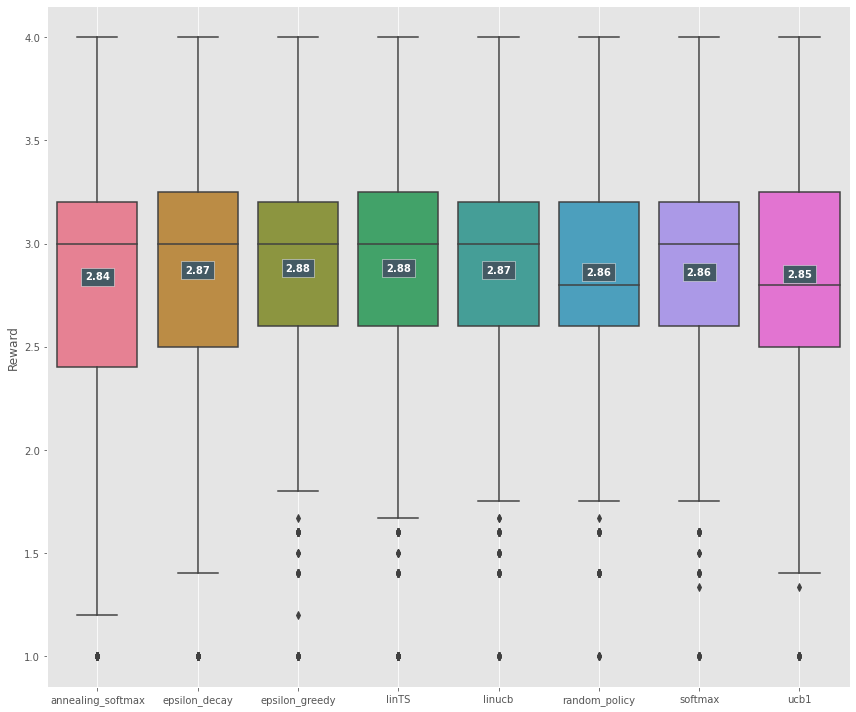

In [62]:
palette: str = "husl"
grouped: str = "policy"
default_value: str = "unknown"
target: str = "reward"

# Retrieve labels and additional parameters to plot figures
data_labels: dict = get_labels_colors_from_pandas_column(df = final_evaluation_cat, column = grouped, palette = palette)

plot_multiple_boxplots(data=final_evaluation_cat,
                       grouped_col=grouped,
                       target_col=target,
                       palette=palette)

In [63]:
# Determine the cumulative reward at 1000 time step
final_evaluation_cat.groupby(['policy'], as_index = False).aggregate({"cumulative_reward":"max"}).sort_values(by=["cumulative_reward"], ascending = False)

,policy,cumulative_reward
4,linucb,9833.733333
7,ucb1,9620.766667
3,linTS,9552.416667
1,epsilon_decay,8366.016667
0,annealing_softmax,8051.100000
2,epsilon_greedy,7389.100000
6,softmax,7353.900000
5,random_policy,7143.450000


Text(0.5, 1.0, 'Cumulative rewards at each step')

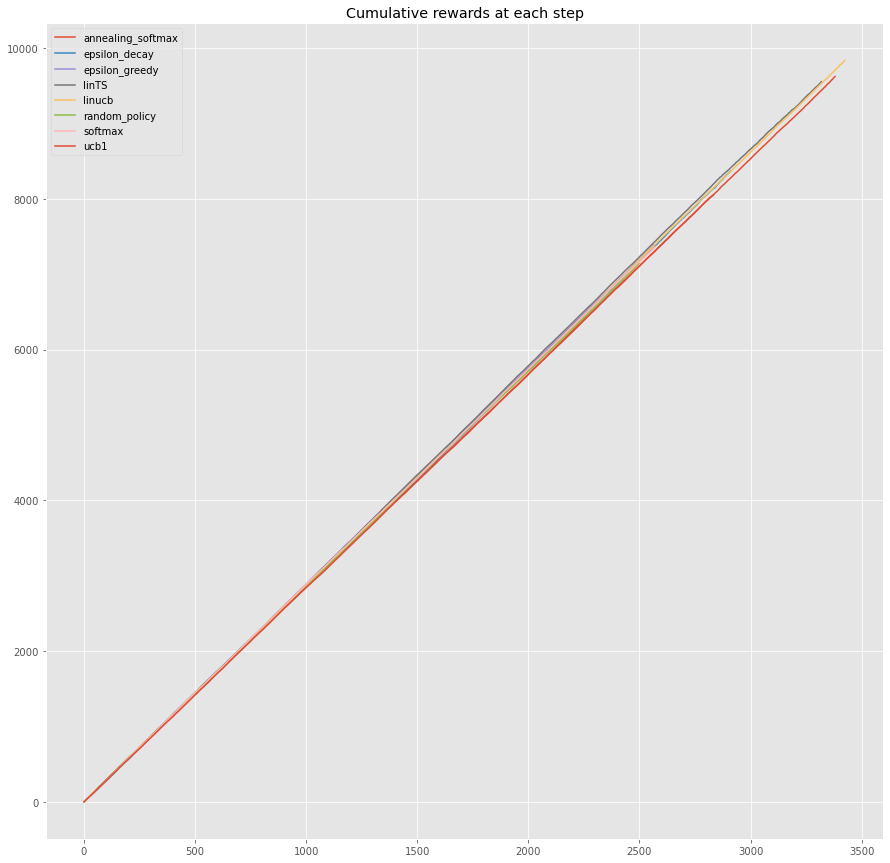

In [64]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation_cat['policy'].unique():
    results_policy = final_evaluation_cat[final_evaluation_cat['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))

plt.legend()
plt.title("Cumulative rewards at each step")

Text(0.5, 1.0, 'Cumulative rewards at each step')

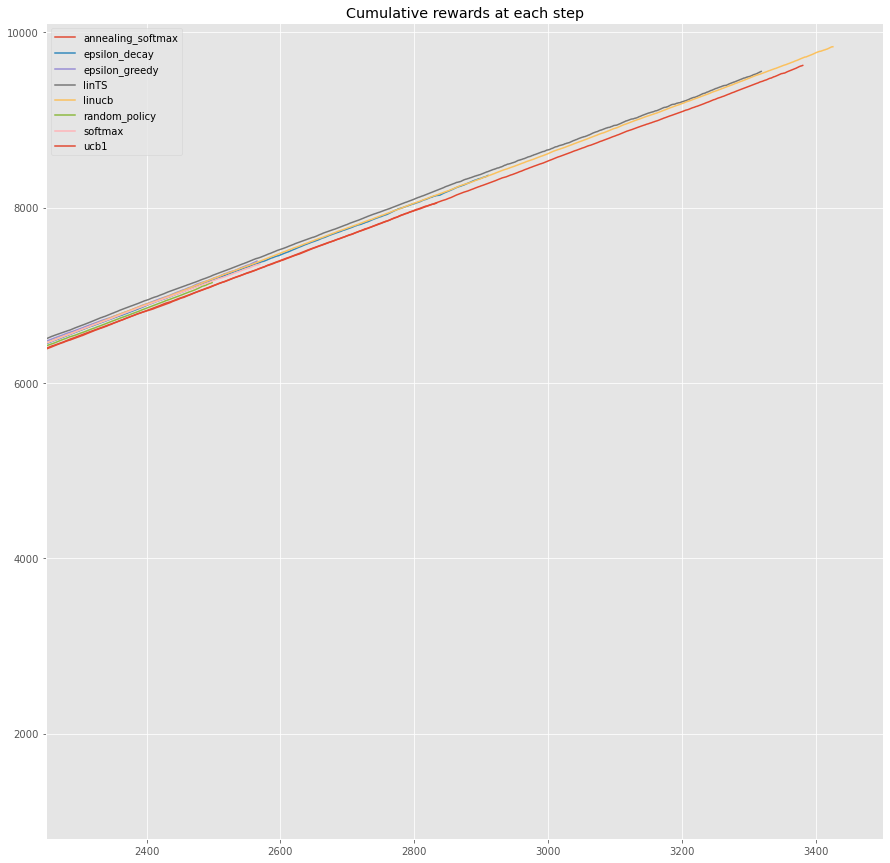

In [65]:
# Plot the cumulative rewards at each time step
plt.style.use('ggplot')

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
for policy in final_evaluation_cat['policy'].unique():
    results_policy = final_evaluation_cat[final_evaluation_cat['policy'] == policy]
    ax.plot(results_policy['time_step'], results_policy['cumulative_reward'], label = str(policy))
    
plt.xlim(2250, 3500)
plt.ylim(800, 10100)
plt.legend()
plt.title("Cumulative rewards at each step")